In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import plotly.figure_factory as ff
import plotly.express as px
import random
import seaborn as sns
import scipy.stats as stats
import uuid
from cassandra.cluster import Cluster
from datetime import datetime
from io import StringIO
from geopy import Nominatim
from meteostat import Hourly, Stations, Point
from pymongo.mongo_client import MongoClient
from pymongo.server_api import ServerApi
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
from scipy.fft import dct, idct

plt.style.use("ggplot")

In [2]:
# Connecting to MongoDB 
url = (
    "mongodb+srv://medvetslos:"
    + json.load(open("../../.nosync/mongoDB.json"))["pwd"]
    + "@ind320-project.lunku.mongodb.net/?retryWrites=true&w=majority&appName=IND320-project"
)

mdb_client = MongoClient(url, server_api=ServerApi("1"))

try:
    mdb_client.admin.command("ping")
    print("Pinged your deployment. Successfully connected to MongoDB.")
except Exception as exceptionMsg:
    print(exceptionMsg)

database = mdb_client["IND320-project"] # Retrieving MongoDB collections
municipalities = database["municipalities"] # Access the "muncipalities" collection

Pinged your deployment. Successfully connected to MongoDB.


In [3]:
# Set environment variables to make PySpark work
os.environ["JAVA_HOME"] = "/opt/homebrew/opt/openjdk@11/"
os.environ["PYSPARK_PYTHON"] = "python" 
os.environ["PYSPARK_DRIVER_PYTHON"] = "python" 
os.environ["PYSPARK_HADOOP_VERSION"] = "without"

# Spark set up
spark = SparkSession.builder.appName('SparkCassandraApp').\
    config('spark.jars.packages', 'com.datastax.spark:spark-cassandra-connector_2.12:3.4.1').\
    config('spark.cassandra.connection.host', 'localhost').\
    config('spark.sql.extensions', 'com.datastax.spark.connector.CassandraSparkExtensions').\
    config('spark.sql.catalog.mycatalog', 'com.datastax.spark.connector.datasource.CassandraCatalog').\
    config('spark.cassandra.connection.port', '9042').\
    config("spark.driver.memory", "4g").\
    config("spark.executor.memory", "4g").\
    config("spark.task.maxFailures", "10").\
    config("spark.sql.shuffle.partitions", "200").\
    getOrCreate()

keyspace = "ind320_project"

24/11/01 12:03:22 WARN Utils: Your hostname, Aarons-MacBook-Pro.local resolves to a loopback address: 127.0.0.1; using 192.168.11.132 instead (on interface en0)
24/11/01 12:03:22 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Ivy Default Cache set to: /Users/aaron/.ivy2/cache
The jars for the packages stored in: /Users/aaron/.ivy2/jars
com.datastax.spark#spark-cassandra-connector_2.12 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-df7bc086-9477-4203-9c1d-f9b5e88bbb76;1.0
	confs: [default]
	found com.datastax.spark#spark-cassandra-connector_2.12;3.4.1 in central
	found com.datastax.spark#spark-cassandra-connector-driver_2.12;3.4.1 in central


:: loading settings :: url = jar:file:/Users/aaron/Documents/IND320_projects/.venv/lib/python3.12/site-packages/pyspark/jars/ivy-2.5.1.jar!/org/apache/ivy/core/settings/ivysettings.xml


	found org.scala-lang.modules#scala-collection-compat_2.12;2.11.0 in central
	found com.datastax.oss#java-driver-core-shaded;4.13.0 in central
	found com.datastax.oss#native-protocol;1.5.0 in central
	found com.datastax.oss#java-driver-shaded-guava;25.1-jre-graal-sub-1 in central
	found com.typesafe#config;1.4.1 in central
	found org.slf4j#slf4j-api;1.7.26 in central
	found io.dropwizard.metrics#metrics-core;4.1.18 in central
	found org.hdrhistogram#HdrHistogram;2.1.12 in central
	found org.reactivestreams#reactive-streams;1.0.3 in central
	found com.github.stephenc.jcip#jcip-annotations;1.0-1 in central
	found com.github.spotbugs#spotbugs-annotations;3.1.12 in central
	found com.google.code.findbugs#jsr305;3.0.2 in central
	found com.datastax.oss#java-driver-mapper-runtime;4.13.0 in central
	found com.datastax.oss#java-driver-query-builder;4.13.0 in central
	found org.apache.commons#commons-lang3;3.10 in central
	found com.thoughtworks.paranamer#paranamer;2.8 in central
	found org.sca

In [4]:
cluster = Cluster(["localhost"], port=9042)
session = cluster.connect()
keyspace = "ind320_project"

# Creating a keyspace in Cassandra
session.execute(
    "CREATE KEYSPACE IF NOT EXISTS" + 
    " " + 
    keyspace + 
    " " + 
    "WITH REPLICATION = {'class': 'SimpleStrategy', 'replication_factor': 1};"
)

session.set_keyspace(keyspace) # Setting the keyspace to be able to retrieve my tables

In [5]:
# Functions from assignment 1: 

# Creating a view to Cassandra with PySpark
def create_cassandra_view(view_name:str, table_name: str, keyspace_name: str):
    spark.read.format("org.apache.spark.sql.cassandra")\
        .options(table=table_name, keyspace=keyspace_name)\
        .load()\
        .createOrReplaceTempView(view_name)
    print(f"View '{view_name}' created.")

# Creating a create table query for Cassandra. 
def create_cassandra_table_query(df, new_table_name, keyspace_name):
    # Define mapping between Pandas and Cassandra datatypes
    dtype_mapping = {
        'int64': 'int',
        'float64': 'double',
        'object': 'text',
        'bool': 'boolean',
        'datetime64[ns]': 'timestamp'
    }
    
    # Start constructing the CREATE TABLE query
    query = f"CREATE TABLE IF NOT EXISTS {keyspace_name}.{new_table_name} (\n"
    
    # Add primary key column with timeuuid
    columns = ["id timeuuid"]
    
    # Add remaining columns with mapped Cassandra data types
    for col, dtype in df.dtypes.items():
        if col != "id":  # Exclude 'id' to avoid duplication
            cassandra_type = dtype_mapping.get(str(dtype), 'text')  # Default to 'text' if type is unrecognized
            columns.append(f"{col} {cassandra_type}")
    
    # Join columns with commas and specify primary key as 'id'
    columns_str = ",\n    ".join(columns)
    query += f"    {columns_str},\n"
    query += "    PRIMARY KEY (id)\n);"
    
    return query

# Inserting a Pandas DataFrame into Cassandra with PySpark 
def insert_to_cassandra(df: pd.DataFrame , table_name: str, keyspace_name: str): 
# Prompt: How can I add a timeuuid 'id' column when inserting into Cassandra with PySpark
    def generate_timeuuid():
        return str(uuid.uuid1())
    
    timeuuid_udf = udf(generate_timeuuid, StringType())
    spark.createDataFrame(df).withColumn("id", timeuuid_udf())\
        .write.format("org.apache.spark.sql.cassandra")\
        .mode("append")\
        .options(table=table_name, keyspace=keyspace_name)\
        .save()
    
    print("Insertion completed!")

### Geographical locations of municipalities

In [18]:
# Define price_areas based off of energidataservice.dk's definition:
# "DK1 is west of the Great Belt and DK2 is east of the Great Belt."
# https://www.energidataservice.dk/tso-electricity/productionconsumptionsettlement

price_areas = {
    "DK1": ["North", "Central", "South"],
    "DK2": ["Zealand", "Capital"]
}

nominatim = Nominatim(user_agent="personal-application, school") # Initialize a geocoder from GeoPy

# Retrieve only "Region" and "Municipality" from the MongoDB collection
region_municipality = municipalities.find({}, {"Region": 1, "Municipality": 1}) 

# Iterate over every municipality
for row in region_municipality: 
    _id = row["_id"]

    # Set price area
    if row["Region"] in price_areas["DK2"]:
        price_area = "DK2"
    else: 
        price_area = "DK1"

    # Find longitude and latitude of the municipality
    geocode_location = nominatim.geocode(row["Municipality"] + " kommune")
    longitude = geocode_location.longitude
    latitude = geocode_location.latitude

    # Update the MongoDB entry with new values
    update_template = {
        "$set": {
            "Price Area": price_area,
            "Longitude": longitude,
            "Latitude": latitude
        }
    }
    municipalities.update_one({"_id": _id}, update_template) 

### Weather data

In [19]:
start = datetime(2022, 1, 1)
end = datetime(2022, 12, 31, 23, 59)
stations = Stations()

df_weather = pd.DataFrame()

municipality_coords = municipalities.find({}, {"Municipality": 1, "Longitude": 1, "Latitude": 1})

for row in municipality_coords:
    latitude = row["Latitude"]
    longitude = row["Longitude"]
    nearby_stations = stations.nearby(latitude, longitude)
    nearest_station = nearby_stations.fetch(1) # Fetches nearest station to the coordinates given 
    distance = nearest_station["distance"].iloc[0] # Returns distance to nearest station
    
    weather_location = Hourly(Point(latitude, longitude), start, end) # Fetches hourly weather data for the nearest station during the defined period 
    weather_data = weather_location.fetch() # Retrieves hourly weather data for specified period
    weather_data["distance_to_station"] = distance # Creating a column for the distance
    weather_data["municipality"] = row["Municipality"] # Adding a "municipality" column so we can distinguish the data 

    df_weather = pd.concat([df_weather, weather_data]) # Concatenating the weather data subsequently

df_weather = df_weather.reset_index()
df_weather = df_weather.rename(columns={"index": "datetime"})

In [20]:
df_weather

,datetime,temp,dwpt,rhum,prcp,snow,wdir,wspd,wpgt,pres,tsun,coco,distance_to_station,municipality
0,2022-01-01 00:00:00,7.5,7.2,98.0,0.0,NaN,275.0,16.9,33.1,1012.4,NaN,5.0,2336.324166,Copenhagen
1,2022-01-01 01:00:00,7.4,7.3,99.0,0.0,NaN,277.0,16.2,32.8,1013.1,NaN,5.0,2336.324166,Copenhagen
2,2022-01-01 02:00:00,7.3,7.2,99.0,0.0,NaN,285.0,15.8,31.3,1013.5,NaN,5.0,2336.324166,Copenhagen
3,2022-01-01 03:00:00,7.2,6.9,98.0,0.0,NaN,290.0,18.4,36.0,1013.9,NaN,5.0,2336.324166,Copenhagen
4,2022-01-01 04:00:00,7.5,6.9,96.0,0.0,NaN,291.0,20.2,40.0,1014.3,NaN,5.0,2336.324166,Copenhagen
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
762115,2022-12-31 19:00:00,8.0,8.0,100.0,1.2,NaN,180.0,7.6,20.4,1000.0,NaN,8.0,16705.854121,Fanø
762116,2022-12-31 20:00:00,7.0,7.0,100.0,1.0,NaN,170.0,9.4,18.5,999.0,NaN,9.0,16705.854121,Fanø
762117,2022-12-31 21:00:00,7.0,6.9,99.0,0.0,NaN,120.0,5.4,22.2,999.6,NaN,9.0,16705.854121,Fanø
762118,2022-12-31 22:00:00,7.0,7.0,100.0,1.0,NaN,80.0,5.4,14.8,998.0,NaN,8.0,16705.854121,Fanø


In [21]:
cas_weather_table = "weather_data" # Defining a name for my Cassandra table
session.execute(f"DROP TABLE IF EXISTS {keyspace}.{cas_weather_table}") # Executing DROP TABLE  
weather_table = create_cassandra_table_query(df_weather, cas_weather_table, keyspace) # Creating a CREATE TABLE query based off of the DataFrame df_weather
session.execute(weather_table)
insert_to_cassandra(df_weather, cas_weather_table, keyspace) 

24/10/31 10:53:48 WARN TaskSetManager: Stage 0 contains a task of very large size (8194 KiB). The maximum recommended task size is 1000 KiB.


Insertion completed!


## Smoothing and outliers/anomalies

### Gas prices

In [10]:
# Get gas prices from the MongoDB collection "gas"
gas_prices = [entry for entry in database["gas"].find({}, {"PurchasePriceDKK_kWh": 1, "GasDay": 1})] 

df_gas_prices = pd.DataFrame.from_records(gas_prices) # Make a DataFrame from the list of gas prices
df_gas_prices = df_gas_prices.sort_values("GasDay", ascending=True) # Sort the dataframe in temporal order
df_gas_prices.head()

,_id,GasDay,PurchasePriceDKK_kWh
91,6709103c43f4e1efbf67a110,2022-10-01,1.2209
90,6709103c43f4e1efbf67a10f,2022-10-02,1.1672
89,6709103c43f4e1efbf67a10e,2022-10-03,1.0476
88,6709103c43f4e1efbf67a10d,2022-10-04,0.8667
87,6709103c43f4e1efbf67a10c,2022-10-05,0.6087


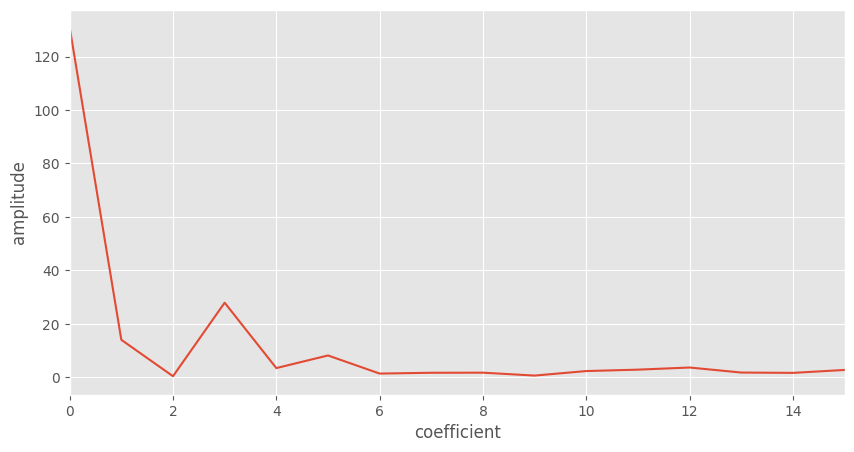

In [47]:
W = np.arange(0, df_gas_prices.shape[0])
dct_gas_prices = dct(df_gas_prices["PurchasePriceDKK_kWh"].values) # DCT on the gas prices

# Plotting of the DCT
num_coeff = 15

plt.figure(figsize=(10, 5))
plt.plot(np.abs(dct_gas_prices))
plt.xlabel('coefficient') 
plt.ylabel('amplitude')
# plt.xlim(0, dct_gas_prices.shape[0])
plt.xlim(0, num_coeff)
plt.xticks(np.arange(0, num_coeff+1, step=2))
plt.show()

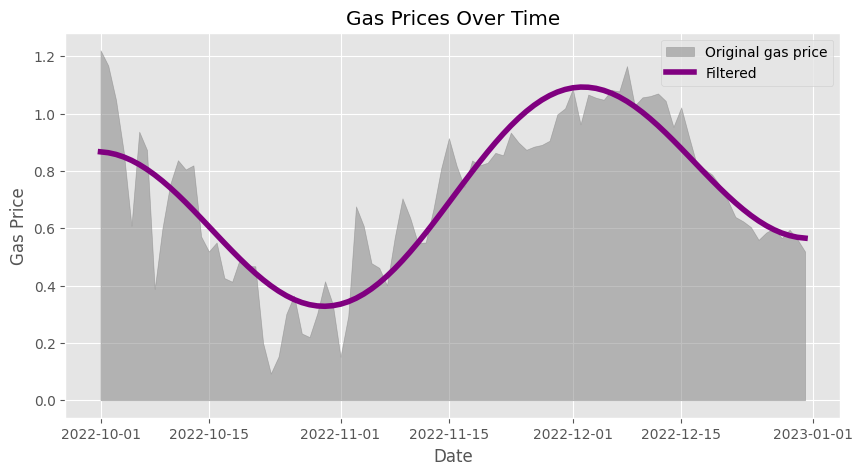

In [ ]:
dct_gas_prices[(W > 3)] = 0 # Filter out frequencies greater than 3

plt.figure(figsize=(10, 5))
plt.fill_between(df_gas_prices['GasDay'], df_gas_prices['PurchasePriceDKK_kWh'], 
                 color='grey', alpha=0.5, label="Original gas price")
plt.xlabel('Date')
plt.ylabel('Gas Price')
plt.title('Gas Prices Over Time')
plt.plot(df_gas_prices['GasDay'], idct(dct_gas_prices), label="Filtered",
         color="purple", linewidth=4)
plt.legend()
plt.show()

### Electricity exchange

In [58]:
df_exchangeNO

,exchangeno_mwh
hourdk,
2022-01-01 00:00:00,-1131.8420
2022-01-01 01:00:00,-1132.2717
2022-01-01 02:00:00,-1132.2246
2022-01-01 03:00:00,-1132.4853
2022-01-01 04:00:00,-1132.6553
...,...
2022-12-31 19:00:00,-1518.6320
2022-12-31 20:00:00,-1594.0509
2022-12-31 21:00:00,-1666.7344


In [82]:
create_cassandra_view("prodcons_view", "prodcons", keyspace)  # Create a view to access the "prodcons" table
df_exchangeNO = spark.sql("SELECT hourdk, exchangeno_mwh FROM prodcons_view").toPandas()
df_exchangeNO = df_exchangeNO.groupby("hourdk").aggregate({"exchangeno_mwh": "sum"}) # Aggregate sum such that we get the total exchange for DK1 and DK2

# Mean and standard deviation of the electricity exchange
mean_exchangeNO = df_exchangeNO["exchangeno_mwh"].mean()
std_exchangeNO = df_exchangeNO["exchangeno_mwh"].std()
print(f"Mean: {mean_exchangeNO:.1f}")
print(f"Standard deviation: {std_exchangeNO:.1f}")

View 'prodcons_view' created.
Mean: 228.6
Standard deviation: 1013.0


In 2022, the danes on average imported $228.6\ MWh$ of energy a day from Norway with a standard deviation of $1013\ MWh$. The standard deviation very varying amount energy being either imported or exported.

In [87]:
# Robust statistics
k = 1.4826 # k with the assumption that our data is normally distributed
trim_mean_exchangeNO = stats.trim_mean(df_exchangeNO["exchangeno_mwh"], 0.05) # Trimmed mean removing 5% of the most extreme observations
MAD_exchangeNO = stats.median_abs_deviation(df_exchangeNO["exchangeno_mwh"])
print(f"Trimmed mean: {trim_mean_exchangeNO:.3f}")
print(f"MAD: {MAD_exchangeNO:.3f}")
print(f"Adjusted MAD: {MAD_exchangeNO * k:.3f}")

Trimmed mean: 256.473
MAD: 694.875
Adjusted MAD: 1030.222



Trimmed mean is different from the normal mean statistic as we remove a percentage of the most extreme observations, here 5%. Since we are removing a proportion, the number of samples becomes smaller which results in a "bigger" mean value than the original mean.

Median absolute devation differs from standard deviation, but it has a relation to it by multiplying it by $k \approx 1.4826$ if we assume that our data is normally distributed. By multiplying by $k$ we get a value more similair to the standard deviation $\hat{\sigma}$ approximated above. We see that our adjusted $MAD$-value differs slightly from the standard deviation we estimated above.

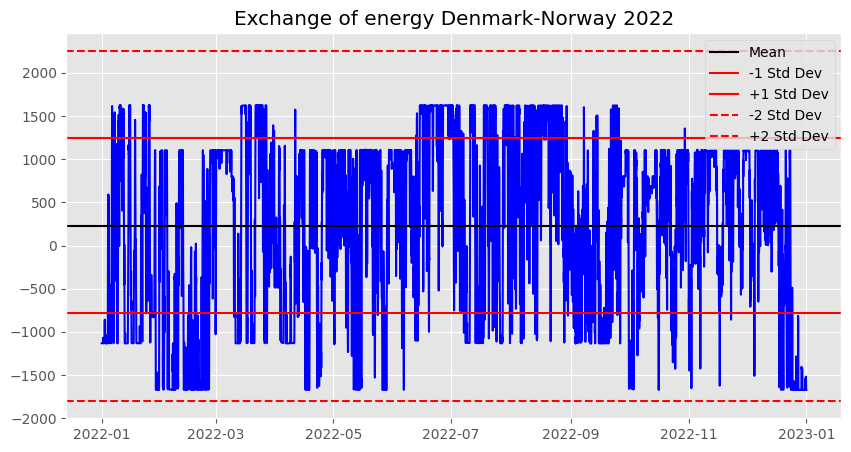

In [90]:
plt.figure(figsize=(10, 5))
plt.plot(df_exchangeNO.index, df_exchangeNO["exchangeno_mwh"], color="blue")
plt.title("Exchange of energy Denmark-Norway 2022")
plt.axhline(mean_exchangeNO, color="black", label="Mean")
plt.axhline(mean_exchangeNO - std_exchangeNO, color="red", label="-1 Std Dev")
plt.axhline(mean_exchangeNO + std_exchangeNO, color="red", label="+1 Std Dev")
plt.axhline(mean_exchangeNO - 2 * std_exchangeNO, color="red", linestyle="--", label="-2 Std Dev")
plt.axhline(mean_exchangeNO + 2 * std_exchangeNO, color="red", linestyle="--", label="+2 Std Dev")
plt.legend()
plt.show()

In [ ]:
upper_spc = mean_exchangeNO + 3 * std_exchangeNO
lower_spc = mean_exchangeNO - 3 * std_exchangeNO

print(lower_spc, upper_spc)

-2810.4330951104407 3267.5362585775033


If we assume any measurement outside $\pm 3$ to be an outlier, the export of energy has to be greater than $2810\ MWh$ or the import has to be greater than $3267\ MWh$ before we flag it.

## Imputation

In [6]:
# Get gas prices from my MongoDB collection "gas" 
gas_prices = [entry for entry in database["gas"].find({}, {"PurchasePriceDKK_kWh": 1, "GasDay": 1})]

# Create views to access my Cassandra tables
create_cassandra_view("prodcons_view", "prodcons", keyspace)  
create_cassandra_view("production_view", "production", keyspace)
create_cassandra_view("consumption_view", "consumption", keyspace)
create_cassandra_view("weather_view", "weather_data", keyspace)

# Retrieve and prepare DataFrames 
df_municipalities = pd.DataFrame.from_records([entry for entry in municipalities.find({})]) 
df_gas_prices = pd.DataFrame.from_records(gas_prices)
df_prodcons = spark.sql("SELECT * FROM prodcons_view").toPandas()
df_production = spark.sql("SELECT * FROM production_view").toPandas()
df_consumption = spark.sql("SELECT * FROM consumption_view").toPandas()
df_weather_data = spark.sql("SELECT * FROM weather_view").toPandas()

24/11/01 12:03:42 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


View 'prodcons_view' created.
View 'production_view' created.
View 'consumption_view' created.
View 'weather_view' created.


### Checking for missing values in each dataframe

In [29]:
dfs = {"gas_prices": df_gas_prices, "prodcons": df_prodcons, 
       "production": df_production, "consumption": df_consumption, 
       "weather_data": df_weather_data, "municipalities": df_municipalities}

for key, df in dfs.items():
    na_df = df.isna().sum() # Get sum of NAs for every column of the DataFrame
    non_zero_na_df = na_df[na_df > 0] # Filter out the columns that does not have NAs

    # Print out a summary of missing values in a DataFrame if there is any
    if not non_zero_na_df.empty: 
       print(f"\n{key} - {df.shape}:")
       print(non_zero_na_df)


prodcons - (17520, 29):
exchangegb_mwh    17520
exchangenl_mwh     8760
exchangeno_mwh     8760
dtype: int64

production - (871393, 9):
offshorewindge100mw_mwh    818834
offshorewindlt100mw_mwh    801313
solarmwh                     8760
thermalpowermwh            123888
dtype: int64

weather_data - (762120, 15):
coco     48361
dwpt      2658
prcp    158466
pres      2658
rhum      2658
snow    718431
temp      2658
tsun    720638
wdir      2661
wpgt      2723
wspd      2658
dtype: int64


In [14]:
# A function to create an overview of the number and proportion missing 
# values in a DataFrame
def na_overview(df: pd.DataFrame):
    na_df = df.isna().sum()
    na_df = na_df[na_df > 0].to_frame(name="# missing values")
    na_df["% missing values"] = na_df["# missing values"] / df.shape[0]
    print(df.shape)
    return na_df

#### Prodcons

In [92]:
na_prodcons = na_overview(df_prodcons)
na_prodcons

NameError: name 'df_prodcons' is not defined

In [32]:
# Trying to assess a pattern as the missing values makes out either half 
# of the dataset or its entire length 
df_prodcons_na = df_prodcons[["hourdk", "pricearea", "exchangeno_mwh", 
                              "exchangenl_mwh", "exchangegb_mwh"]].copy()
df_prodcons_na = df_prodcons_na.sort_values("hourdk", ascending=True)
df_prodcons_na.head(8)

,hourdk,pricearea,exchangeno_mwh,exchangenl_mwh,exchangegb_mwh
12792,2022-01-01 00:00:00,DK1,-1131.8420,-621.410,NaN
7345,2022-01-01 00:00:00,DK2,NaN,NaN,NaN
6830,2022-01-01 01:00:00,DK2,NaN,NaN,NaN
2389,2022-01-01 01:00:00,DK1,-1132.2717,-583.754,NaN
17219,2022-01-01 02:00:00,DK1,-1132.2246,-554.725,NaN
1199,2022-01-01 02:00:00,DK2,NaN,NaN,NaN
3707,2022-01-01 03:00:00,DK2,NaN,NaN,NaN
6821,2022-01-01 03:00:00,DK1,-1132.4853,-237.741,NaN


In [33]:
# Checking if the Netherlands and Norway only exchange energy 
# with pricearea DK2 during this period. If they happen to 
# do so, we should see "False" printed out.
print(df_prodcons[df_prodcons["exchangeno_mwh"].notna()].query("pricearea == 'DK2'").empty)
print(df_prodcons[df_prodcons["exchangenl_mwh"].notna()].query("pricearea == 'DK2'").empty)

True
True


For **prodcons** we have missing data for the exchange of energy to Great Britain, the Netherlands and Norway. Great Britain has no import or export of energy during the period of our data, hence 17520 total missing values. For both the Netherlands and Norway we have half of the missing values as Great Britain. This can be attributed to these countries only exchanging energy with `pricearea` "DK1". We can interperet the NaNs as lack of activity during this period.

Imputing any of these missing values would not be appropriate.

#### Production

In [104]:
na_production = na_overview(df_production)
na_production

(871393, 9)


,# missing values,% missing values
offshorewindge100mw_mwh,818834,0.939684
offshorewindlt100mw_mwh,801313,0.919577
solarmwh,8760,0.010053
thermalpowermwh,123888,0.142172


**production** is missing quite a lot of data in its offshore wind production, both missing more than 90% of data. The fraction of values missing would not be appropriate to impute.

However, solar and thermal energy production is missing less data which would be more feasible to impute.

In [ ]:
# create_cassandra_view("production_view", "production", keyspace)  
# df_production = spark.sql("SELECT * FROM production_view").toPandas()

df_production = df_production.sort_values("hourdk", ascending=True)
df_production.set_index("hourdk", inplace=True)

# Original values
solarpowermwh_og = df_production["solarmwh"].dropna().values
thermalpowermwh_og = df_production["thermalpowermwh"].dropna().values

# Interpolating missing values using "time" as computation isn't too long 
df_production["solarmwh"] = df_production["solarmwh"].interpolate("time")
df_production["thermalpowermwh"] = df_production["thermalpowermwh"].interpolate("time")

df_production.reset_index(inplace=True)

View 'production_view' created.


KeyboardInterrupt: 

In [ ]:
# Double checking if we've managed to our chosen columns
na_production_imp = na_overview(df_production)
na_production_imp

(871393, 9)


,# missing values,% missing values
offshorewindge100mw_mwh,818834,0.939684
offshorewindlt100mw_mwh,801313,0.919577


In [37]:
def plot_NA(df: pd.DataFrame, value_column: str, time_column: str):
    df = df.copy()
    df.set_index(time_column, inplace=True)

    df_not_null = df[value_column].notnull()

    plt.figure(figsize=(10, 5))
    plt.vlines(df_not_null.index, ymin=0, ymax=1, 
               colors=df_not_null.map({True: 'black', False: 'white'}), 
               linewidth=1)
    plt.xlabel('Time')
    plt.ylabel('Presence of Data')
    plt.title(f'Presence of {value_column} Over Time')
    plt.show()

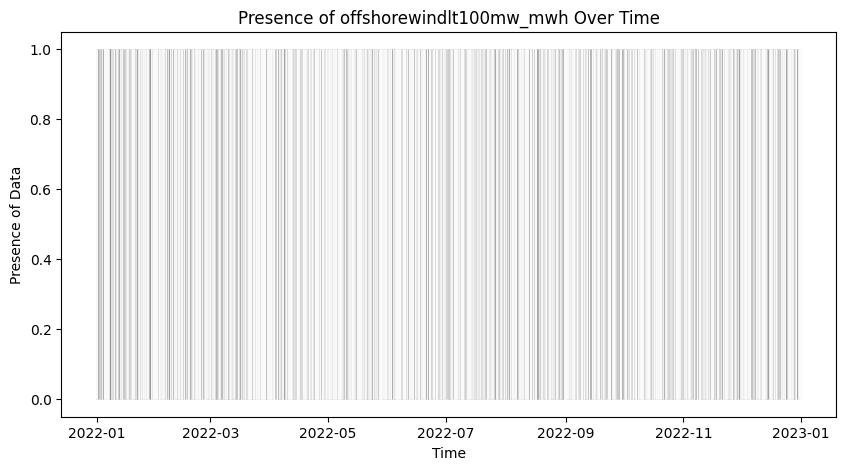

In [38]:
plot_NA(df_production, "offshorewindlt100mw_mwh", "hourdk")

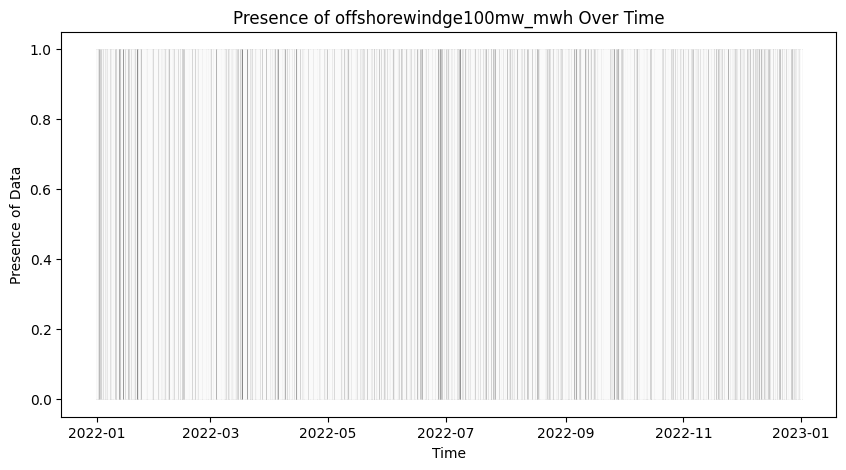

In [39]:
plot_NA(df_production, "offshorewindge100mw_mwh", "hourdk")

#### Weather data

In [ ]:
# Checking the number and proportion of missing values 
# in the weather DataFrame
na_weather = na_overview(df_weather_data)
na_weather

(762120, 15)


,# missing values,% missing values
coco,48361,0.063456
dwpt,2658,0.003488
prcp,158466,0.207928
pres,2658,0.003488
rhum,2658,0.003488
snow,718431,0.942674
temp,2658,0.003488
tsun,720638,0.945570
wdir,2661,0.003492
wpgt,2723,0.003573


In [41]:
# Finding the stations where "snow" and "tsun" is being measured to assess
# why there are many missing values
df_snow = df_weather_data[df_weather_data["snow"].notna()]
df_tsun = df_weather_data[df_weather_data["tsun"].notna()]
print(df_snow["municipality"].unique())
print(df_tsun["municipality"].unique())

['Tønder' 'Lolland' 'Sønderborg' 'Aabenraa' 'Ærø']
['Tønder' 'Sønderborg' 'Lolland' 'Aabenraa' 'Ærø']


In [42]:
# Check if there are any missing values for the locations which measures `snow` and `tsun`
tsun_snow_locations = df_snow["municipality"].unique()
df_tsun_snow = df_weather_data[df_weather_data["municipality"].isin(tsun_snow_locations)]
df_tsun_snow_na = df_tsun_snow.isna().sum()
df_tsun_snow_na[df_tsun_snow_na> 0]

snow     111
tsun    2318
dtype: int64

**weather_data** is missing a lot of data for `snow` which at first glance is sensible since there isn't snow all year round. But upon further investigation, `snow` is only measured at a handful of stations. This is also the case for `tsun` which is measured at the same stations, hence the big number of missing values. Having to impute this for the rest of the stations would be unreasonable as no measurements exists at these locations. 

In [10]:
# Retrieve all municipalities with precipitation measurements
prcp_measured = df_weather_data[df_weather_data["prcp"].notna()]["municipality"].unique() 

# Use the symmetric difference operator "^".
# Between two sets, it returns values not shared by both sets. 
# In this case we return municipalities which does not measure precipitation at all.
na_prcp = set(prcp_measured)^set(df_weather_data["municipality"].unique()) 

print(na_prcp)

{'Skive', 'Lemvig', 'Helsingør', 'Struer', 'Gribskov', 'Odsherred', 'Morsø', 'Vesthimmerland', 'Thisted', 'Halsnæs'}


The missing values for `prcp` is partly due to 10 stations not measuring percipitation at all. Imputing the precipitation for these stations would not make sense. The remaining missing values comes from stations which do measure percipitation and these we can impute.

`dwpt`, `pres`, `rhum`, and `wspd` are missing the same amount of data.

`coco` is an integer indicating the weather condition as noted in the [documentation](https://dev.meteostat.net/formats.html#weather-condition-codes). Imputing these could give a false indication of the weather.

For the remaining features it would be reasonable to impute the missing values as the numbers are relatively small.

##### Imputation

In [7]:
# Preparing DataFrame for interpolation
df_weather_data = df_weather_data.sort_values("datetime", ascending=True)
df_weather_data.set_index("datetime", inplace=True)

In [8]:
# Impute `tsun` and `snow` for 'Sønderborg', 'Ærø', 'Lolland', 'Aabenraa' and 'Tønder'

# Get municipalities which measures `tsun` and `snow`
loc_snow_tsun = df_weather_data[df_weather_data["tsun"].notna()]["municipality"].unique() 

# Creating a copy with our desired municipalities 
df_snow_tsun = df_weather_data[df_weather_data["municipality"].isin(loc_snow_tsun)].copy() 

# Imputing the values by using "time" in .interpolation
df_snow_tsun[["snow", "tsun"]] = df_snow_tsun[["snow", "tsun"]].interpolate("time")

# Replace the existing "snow" and "tsun" measurements with their imputed counterparts
df_weather_data.loc[df_weather_data["municipality"].isin(loc_snow_tsun), 
                    ["snow", "tsun"]] = df_snow_tsun[["snow", "tsun"]].values

In [11]:
# Impute `prcp` for every municipality but 'Morsø', 'Lemvig', 'Helsingør', 'Struer', 'Halsnæs', 'Odsherred', 'Skive', 'Gribskov', 'Thisted' and 'Vesthimmerland'
exclude_list = list(na_prcp)

# Excluding municipalities/weather stations that does not measure precipitation
df_weather_data_prcp = df_weather_data[~df_weather_data["municipality"].isin(exclude_list)].copy() 

# Imputing the values by using "time" in .interpolation
df_weather_data_prcp["prcp"] = df_weather_data_prcp["prcp"].interpolate("time")

# Insert the imputed `prcp`-values where they belong
df_weather_data.loc[~df_weather_data["municipality"].isin(exclude_list), ["prcp"]] = df_weather_data_prcp["prcp"].values 

In [12]:
# Impute remaining missing values for columns not named `prcp`, `snow`, `tsun` and `coco`

# Exlcude the following columns from the imputation procedure
# since we've imputed them as seen above
exclude_cols = ["prcp", "snow", "tsun", "coco"]

# Create a copy and impute values 
df_weather_impute = df_weather_data.copy().drop(columns=exclude_cols)
df_weather_impute = df_weather_impute.interpolate("time")

# Insert the imputed values to their respective places
df_weather_data.update(df_weather_impute)
df_weather_data.reset_index(inplace=True)

In [15]:
# Double check to see if have managed to impute values 
# in our desired columns
na_overview(df_weather_data)

(762120, 15)


,# missing values,% missing values
coco,48361,0.063456
prcp,87600,0.114943
snow,718320,0.942529
tsun,718320,0.942529


### Synchronization

In [ ]:
def sync_weather_to_gas(weather_df: pd.DataFrame, gas_df: pd.DataFrame, 
                        time_weather: str, time_gas: str, 
                        weather_property: str, municipality: str,
                        accumulation_mtd: str = "mean"): 

    # Dropping "id" as it will be a hurdle when aggregating 
    weather_df = weather_df.drop(labels="id", axis=1)
    gas_df = gas_df.drop(labels="_id", axis=1) 

    # Filter weather_df w.r.t. municipality
    weather_df = weather_df.query(f"municipality == '{municipality}'")

    # Sort the DataFrames in temporal order 
    weather_df = weather_df.sort_values(time_weather, ascending=True)
    gas_df = gas_df.sort_values(time_gas, ascending=True)

    # Rename the time_gas column to time_weather
    gas_df = gas_df.rename(columns={time_gas: time_weather})

    # Set the index to their time column
    weather_df.set_index(time_weather, inplace=True)
    gas_df.set_index(time_weather, inplace=True)

    # Only have mean implemented, but could be further extended
    if accumulation_mtd == "mean":
        weather_df = weather_df.groupby("municipality").resample("D").mean()

    # Merging the two DataFrames on their respective time column
    combined_df = pd.merge(weather_df, gas_df, on=time_weather)

    return combined_df[[weather_property, "PurchasePriceDKK_kWh"]] 

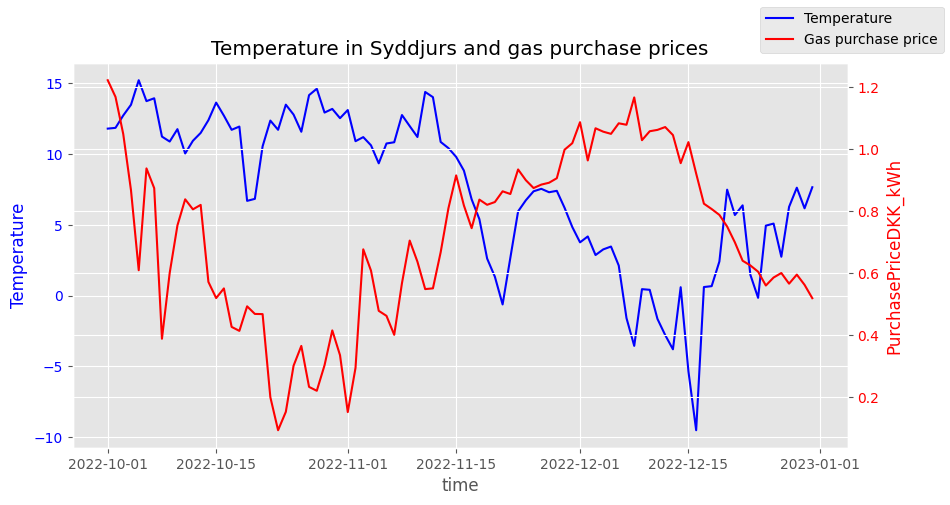

In [28]:
random.seed(1234341)

rand_municipality = random.choice(df_weather_data["municipality"].unique())
df_random = sync_weather_to_gas(df_weather_data, df_gas_prices, "datetime", "GasDay", "temp", rand_municipality)

fig, ax1 = plt.subplots(figsize=(10,5))
ax1.plot(df_random.index, df_random["temp"], 
         color='b', label='Temperature')
ax1.set_xlabel("time")
ax1.set_ylabel("Temperature", color="b")
ax1.tick_params(axis="y", labelcolor="b")

ax2 = ax1.twinx()
ax2.plot(df_random.index, df_random["PurchasePriceDKK_kWh"], 
         color='r', label='Gas purchase price')
ax2.set_ylabel("PurchasePriceDKK_kWh", color="r")
ax2.tick_params(axis="y", labelcolor="r")

fig.legend(loc="upper right")
plt.title(f"Temperature in {rand_municipality} and gas purchase prices")

plt.show()